<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-5/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
business = pd.read_csv('../../datasets/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('../../datasets/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('../../datasets/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('../../datasets/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('../../datasets/yelp_arizona_data/users_small_parsed.csv')

In [3]:
print business.shape
print business.columns

business.head(1)

(152832, 11)
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False


In [4]:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
#unique_categories = set(list(itertools.chain(*categories.tolist())))

In [5]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']
    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)

In [6]:
business_copy.head(1)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,...,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,...,False,False,False,False,True,False,False,False,False,False


In [7]:
print tips.shape, tips.columns
tips.describe()

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24 hours',
       u'amazing food', u'animal style', u'awesome food', u'awesome place',
       u'awesome service',
       ...
       u'service good', u'service great', u'slow service', u'staff friendly',
       u'staff great', u'steak eggs', u'super friendly', u'sweet potato',
       u'velvet pancakes', u'worth wait'],
      dtype='object', length=104)


,likes,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,...,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
count,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,...,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000
mean,0.015403,0.001481,0.002432,0.002128,0.002226,0.001304,0.001245,0.001245,0.002216,0.002275,...,0.002373,0.004167,0.001883,0.001549,0.001441,0.001500,0.001471,0.002549,0.002039,0.001784
std,0.137377,0.038449,0.049251,0.047544,0.047332,0.036088,0.035266,0.035543,0.047229,0.047640,...,0.048854,0.064570,0.043347,0.039329,0.037937,0.039206,0.038322,0.050620,0.045114,0.042206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


In [8]:
print reviews.columns, reviews.shape
reviews.head(1)

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108) (322398, 108)


,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print users.shape, users.columns
users.head(1)

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [10]:
business_vegas = business_copy[business_copy['city'] == 'Las Vegas']
# business_phoenix = business_copy[business_copy['city'] == 'Phoenix']
# business_surprise = business_copy[business_copy['city'] == 'Surprise']
# business_waterloo = business_copy[business_copy['city'] == 'Waterloo']
business_not_vegas = business_copy[business_copy['city'] != 'Las Vegas']

In [11]:
business_vegas.Burgers[business_vegas['Burgers'] == True].count()

14086

In [12]:
bvegas = (business_vegas==1).sum()
bvegas = bvegas[11:].reset_index()
bvegas.columns = ['Business', 'Las Vegas']
# bphoenix = (business_phoenix==1).sum()
# bphoenix = bphoenix[11:].reset_index()
# bphoenix.columns = ['Business', 'Phoenix']
# bsurprise = (business_surprise==1).sum()
# bsurprise = bsurprise[11:].reset_index()
# bsurprise.columns = ['Business', 'Surprise']
# bwaterloo = (business_waterloo==1).sum()
# bwaterloo = bwaterloo[11:].reset_index()
# bwaterloo.columns = ['Business', 'Waterloo']


notvegas = (business_not_vegas==1).sum()
notvegas = notvegas[11:].reset_index()
notvegas.columns = ['Business', 'Not Vegas']

In [13]:
businesstypes = bvegas.merge(notvegas)

#businesstypes = businesstypes.merge(bsurprise)
#businesstypes = businesstypes.merge(bwaterloo)
businesstypes

# notvegas = bphoenix.merge(bsurprise)
# notvegas = notvegas.merge(bwaterloo)
# notvega

,Business,Las Vegas,Not Vegas
0,Airports,19,35
1,Breakfast & Brunch,9734,9502
2,Bubble Tea,647,147
3,Burgers,14086,11426
4,Bars,36983,20372
5,Bakeries,4743,3920
6,Breweries,858,610
7,Cafes,5736,3857
8,Candy Stores,612,266
9,Comedy Clubs,962,197


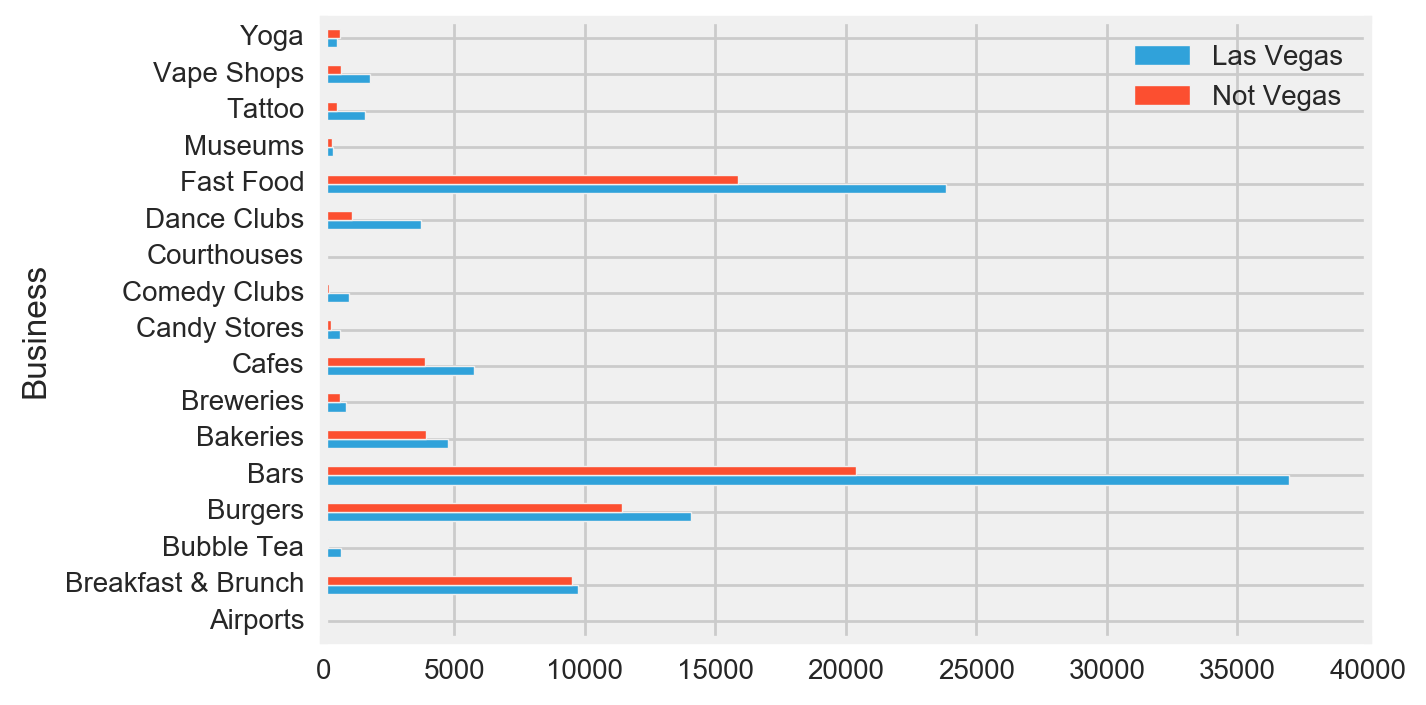

In [14]:
businesstypes.plot(kind='barh', x='Business');

In [15]:
# bvegas.plot.bar(x='Business')
# bphoenix.plot.bar(x='Business')
# bsurprise.plot.bar(x='Business')
# bwaterloo.plot.bar(x='Business')

In [16]:
#citydict = {'Las Vegas': 1, 'Phoenix':2, 'Surprise':3 , 'Waterloo': 4}
citydict = {'Las Vegas': 1, 'Phoenix':0, 'Surprise':0 , 'Waterloo': 0}
business_copy['city'] = business_copy['city'].map(citydict)

In [17]:
categories = business_copy.columns[11:].tolist()
categories

['Airports',
 'Breakfast & Brunch',
 'Bubble Tea',
 'Burgers',
 'Bars',
 'Bakeries',
 'Breweries',
 'Cafes',
 'Candy Stores',
 'Comedy Clubs',
 'Courthouses',
 'Dance Clubs',
 'Fast Food',
 'Museums',
 'Tattoo',
 'Vape Shops',
 'Yoga']

In [18]:
def truefalse(cat):
    tf = {'True' : 1, 'False' : 0}
    for x, y in tf.items():
        cat = str(cat)
        if x in cat:
            return y
    return 0

for c in categories:
    business_copy[c] = business_copy[c].apply(truefalse)

In [19]:
y = business_copy['city'].values
X = business_copy[business_copy.columns[11:]]

print X.shape, y.shape

(152832, 17) (152832,)


In [20]:
dtcN = DecisionTreeClassifier()

dtcN.fit(X, y)

dtcN_scores = cross_val_score(dtcN, X, y, cv=4)

print dtcN_scores, np.mean(dtcN_scores)

[ 0.62579497  0.62548091  0.62629885  0.62622033] 0.625948762323


In [21]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()

In [22]:
rf.fit(X, y)
rf_scores = cross_val_score(rf, X, y, cv=4)
rf_scores, np.mean(rf_scores)

(array([ 0.6257688 ,  0.62548091,  0.62627267,  0.62622033]),
 0.62593567605797928)

In [23]:
et.fit(X, y)
et_scores = cross_val_score(et, X, y, cv=4)
et_scores, np.mean(et_scores)

(array([ 0.62579497,  0.62548091,  0.62629885,  0.62622033]),
 0.62594876232264496)

In [24]:
dtr_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4],
    'min_samples_split':[2,3,4,5,10]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtr_params, cv=5, verbose=1, n_jobs=-1)
dtc_gs.fit(X, y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   51.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4], 'min_samples_split': [2, 3, 4, 5, 10], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [25]:
dtc_best = dtc_gs.best_estimator_
print dtc_gs.best_params_
print dtc_gs.best_score_

{'max_features': None, 'min_samples_split': 2, 'max_depth': None}
0.625935667923


In [26]:
## Print Feature importances
feature_importance = pd.DataFrame({'feature':categories, 
                                   'importance':dtc_best.feature_importances_})

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance

,feature,importance
1,Breakfast & Brunch,0.211809
3,Burgers,0.177771
4,Bars,0.134400
7,Cafes,0.108556
11,Dance Clubs,0.073203
12,Fast Food,0.070783
5,Bakeries,0.058665
16,Yoga,0.044208
2,Bubble Tea,0.038917
9,Comedy Clubs,0.026289


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
        service, not service
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
        service, not service
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [27]:
reviews_copy = reviews.copy()
tips_copy = tips.copy()
#reviews_tip = reviews_copy.merge(tips_copy, on='user_id')
#reviews_tip.head()
reviews_copy.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
#reviews_tip_col = reviews_tip.columns.tolist()
#reviews_tip_col

In [29]:
#service, food, unknown, ambience
ratecat = ['votes.cool', 'votes.funny', 'votes.useful']
reviewsdict = {           
 '10 minutes': 'service',
 '15 minutes': 'service',
 '20 minutes': 'service',
 '30 minutes': 'service',
 'customer service': 'service',
 'food service': 'service',
 'friendly staff': 'service',
 'good service': 'service',
 'good time': 'service',
 'great service': 'service',
 'great time': 'service',
 'minutes later': 'service',
 'right away': 'service',
 'service excellent': 'service',
 'service food': 'service',
 'service friendly': 'service',
 'service good': 'service',
 'service great': 'service',
 'staff friendly': 'service',
 'super friendly': 'service',
 'wait staff': 'service'}

tipsdict = {
 'awesome service': 'service',
 'customer service': 'service',
 'excellent service': 'service',
 'fast service': 'service',
 'food service': 'service',
 'friendly service': 'service',
 'friendly staff': 'service',
 'good service': 'service',
 'great service': 'service',
 'great staff': 'service',
 'service food': 'service',
 'service good': 'service',
 'service great': 'service',
 'slow service': 'service',
 'staff friendly': 'service',
 'staff great': 'service',
 'super friendly': 'service'}

In [30]:
service_reviews = reviews_copy[['stars']].join(reviews_copy[reviewsdict.keys()])
not_service_reviews = reviews_copy[reviewsdict.keys()]
service_reviews.head()

,stars,staff friendly,minutes later,20 minutes,service friendly,customer service,10 minutes,15 minutes,friendly staff,service excellent,...,super friendly,good time,30 minutes,service food,right away,food service,good service,great service,service great,wait staff
0,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
service_reviews['stars'] = service_reviews['stars'].map({5:1, 4:1, 3:1, 2:0, 1:0})

In [32]:
X = service_reviews[service_reviews.columns[1:]]
y = service_reviews['stars']
X.shape, y.shape

((322398, 21), (322398,))

In [33]:
#run model for service
dtcN = DecisionTreeClassifier()

dtcN.fit(X, y)

dtcN_scores = cross_val_score(dtcN, X, y)

print dtcN_scores, np.mean(dtcN_scores)

[ 0.81364338  0.81394115  0.81469488] 0.814093139536


In [34]:
dtr_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtr_params, cv=5, verbose=1, n_jobs=-1)
dtc_gs.fit(X, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  5.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [35]:
dtc_best = dtc_gs.best_estimator_
print dtc_gs.best_params_
print dtc_gs.best_score_

{'max_features': 2, 'min_samples_split': 40, 'max_depth': None}
0.814390908132


In [36]:
feature_importance = pd.DataFrame({'feature':X.columns, 
                                   'importance':dtc_best.feature_importances_})

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
2,20 minutes,0.183645
6,15 minutes,0.135264
5,10 minutes,0.101041
4,customer service,0.098202
1,minutes later,0.079449
13,30 minutes,0.066989
19,service great,0.052762
18,great service,0.047737
0,staff friendly,0.040118
8,service excellent,0.032837


In [37]:
service_cols = service_reviews.columns.tolist()
no_good_cols = ['yelping_since', 'elite', 'name', 'user_id', 'business_id', 'review_id', 'date'] + service_cols
mask = np.logical_not(reviews_copy.columns.isin(no_good_cols))
#mask = np.logical_not(reviews_copy.columns.isin(service_reviews.columns))
not_service = reviews_copy[reviews_copy.columns[mask]]
not_service.columns

Index([u'votes.cool', u'votes.funny', u'votes.useful', u'bar food',
       u'beer selection', u'best ve', u'bloody mary', u'bottle service',
       u'chicken waffles', u'dance floor', u'decided try', u'definitely come',
       u'definitely recommend', u'didn want', u'don know', u'don like',
       u'don think', u'don want', u'eggs benedict', u'fast food', u'feel like',
       u'felt like', u'fish chips', u'food amazing', u'food came',
       u'food delicious', u'food good', u'food great', u'food just',
       u'french fries', u'french toast', u'friday night', u'fried chicken',
       u'good food', u'good place', u'good thing', u'great atmosphere',
       u'great experience', u'great food', u'great place', u'happy hour',
       u'hash browns', u'highly recommend', u'hip hop', u'ice cream',
       u'just like', u'just ok', u'just right', u'las vegas', u'late night',
       u'like place', u'little bit', u'long time', u'looked like',
       u'looks like', u'love place', u'mac cheese', u'ma

In [38]:
X = not_service[not_service.columns]
y = service_reviews['stars']
X.shape, y.shape

((322398, 82), (322398,))

In [39]:
#run model for not service
dtc = DecisionTreeClassifier()

dtc.fit(X, y)

dtc_score = cross_val_score(dtc, X, y)

print dtc_score, np.mean(dtc_score)

[ 0.79664266  0.79666127  0.80586418] 0.799722702994


In [40]:
dtr_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40]
}

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtr_params, cv=5, verbose=1, n_jobs=-1)
dtc_gs.fit(X, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 14.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [41]:
dtc_best = dtc_gs.best_estimator_
print dtc_gs.best_params_
print dtc_gs.best_score_

{'max_features': None, 'min_samples_split': 2, 'max_depth': 4}
0.81422031154


In [43]:
feature_importance = pd.DataFrame({'feature':X.columns, 
                                   'importance':dtc_best.feature_importances_})

feature_importance.sort_values('importance', ascending=False, inplace=True)
feature_importance.head(10)

,feature,importance
0,votes.cool,0.465400
2,votes.useful,0.231906
1,votes.funny,0.221460
77,tasted like,0.080366
69,really good,0.000868
80,ve seen,0.000000
57,make sure,0.000000
56,mac cheese,0.000000
55,love place,0.000000
54,looks like,0.000000


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [44]:
users_copy = users.copy()
users_copy.head(1)

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199


In [45]:
users_copy['elite'] = users_copy['elite'].apply(lambda x: 1 if x != '[]' else 0)

In [46]:
#users_copy['elite'] = users_copy['elite'].apply(lambda x: len(x.split()) if x != '[]' else 0)
users_copy.head()

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,1,Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,1,Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,1,Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,0,Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,1,Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [47]:
no_good_cols = ['yelping_since', 'elite', 'name', 'user_id']
mask = np.logical_not(users_copy.columns.isin(no_good_cols))
X = users_copy[users_copy.columns[mask]]
X.fillna(value=0, inplace=True)
y = users_copy['elite']
X.head()

/Users/lana/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,134.0,11093,38.0,7681,330.0,580.0,14199
1,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,3.60,19.0,732,4.0,908,24.0,120.0,1483
2,2.0,66,2.0,2.0,4,1.0,1.0,1.0,0.0,3.80,1.0,13,0.0,11,0.0,0.0,34
3,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,3.58,2.0,49,0.0,53,1.0,8.0,243
4,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,4.02,16.0,1928,3.0,1109,57.0,70.0,2404


In [48]:
#run model to see get featurs for elite users
lr = LogisticRegression()
logreg = lr.fit(X, y)

#Logistic
cls_scores = cross_val_score(lr, X, y, cv=4)

print 'Logistic Regression:', cls_scores, np.mean(cls_scores)

Logistic Regression: [ 0.94696549  0.94582825  0.94383113  0.94194175] 0.944641655688


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

y_pred = lr.predict(X_test)
lr_score = lr.score(X_test, y_test)

lr_report = classification_report(y_test, y_pred)

print 'LogReg Score:', lr_score
print lr_report

LogReg Score: 0.944580051037
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     31779
          1       0.87      0.63      0.73      4273

avg / total       0.94      0.94      0.94     36052



In [60]:
#run model again without counts of 
#use test train split


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

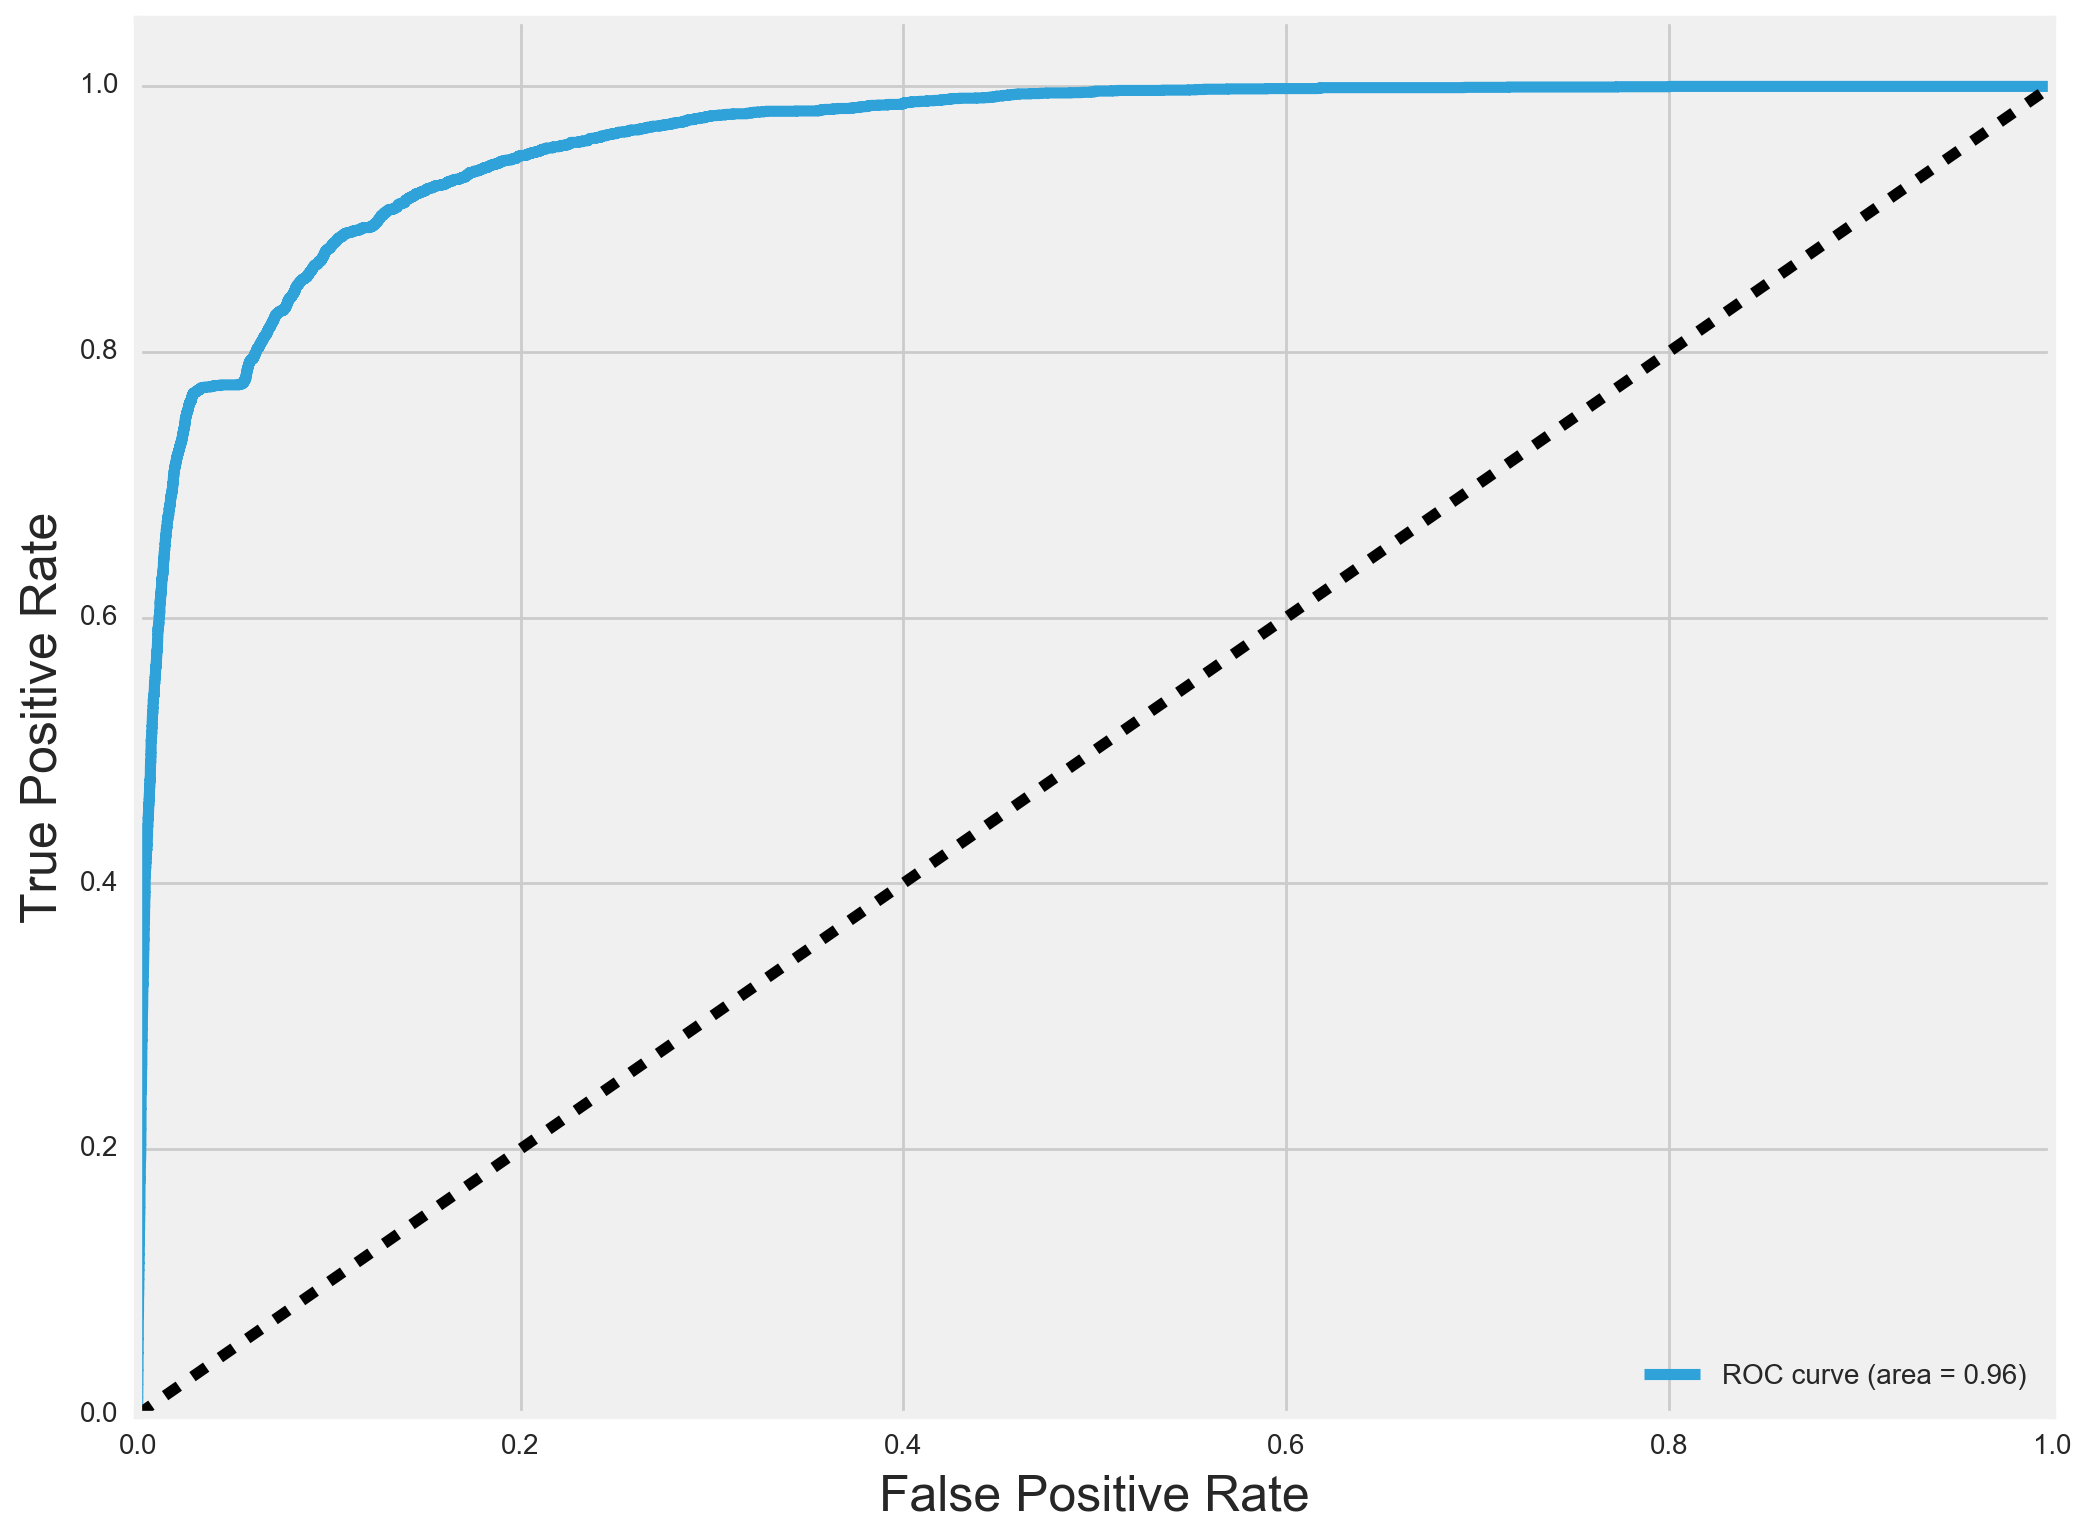

In [58]:
Y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

In [ ]:
#Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.
def binary_search(sorted_list, num):
    if not sorted_list:
        return False
    else:
        mid_idx = len(sorted_list)/2
        midpoint = sorted_list[mid_idx]
        if midpoint == num:
            return True
        elif midpoint > num:
            return binary_search(sorted_list[:mid_idx], num)
        elif midpoint < num:
            return binary_search(sorted_list[mid_idx+1:], num)
        

sorted_list = range(100)

assert binary_search(sorted_list, -1) == False
assert binary_search(sorted_list, 100) == False
assert binary_search(sorted_list, 50) == True
assert binary_search(sorted_list, 101) == False
assert binary_search(sorted_list, 0) == True

#the algorithmic complexity of the Binary Search Algorithm is O(log n) 
#because the list is being divided in half until it is found

In [ ]:
#Implement Merge Sort in Python. What is the time complexity of mergesort?
def merge_sort(input_list):
    if len(input_list) <= 1:
        return input_list
    
    print input_list
    mid = len(input_list) / 2
    left = merge_sort(input_list[:mid])
    print "Left ", left
    right = merge_sort(input_list[mid:])
    print "Right ", right
    return merge(left,right)
    

def merge(left,right):
    if not left:
        return right
    if not right:
        return left
    first_left = left[0]
    first_right = right[0]
    if first_left < first_right:
        return [first_left] + merge(left[1:], right)
    else:
        return [first_right] + merge(left, right[1:])

#the algorithmic complexity of the Binary Search Algorithm is O(n log n) 

In [ ]:
#Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, 
#find the pair whose sum is closest to x and the pair has an element from each array. 
#We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find 
#the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. 
#What is the time complexity of this algorithm?


def closestpair(ar1, ar2, num):
    
    
    
#to figure out logic    
    for i in ar1:
        for j in ar2:
            asum = arl[i]+ar2[j]
            asub = abs(num-asum)
                              
                
    





## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?

- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?

## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 

        Bias-variance tradeoff is about how general or specfic you want your model to be. Bias-variance tradeoff is useful because you want a model that works for any possible cases, not just the data you're testing against. If a model is too general (bias), then it is doesn't really work. If the model is too specfic/complex (variance) then your model will only work is certain cases or just one the data you provided. 
        Cross-validation is a 


- Explain why cross-validation is important.

        Cross-validation is important because it checks your model with your data to ensure that you don't overfit your model. It is also good pratice to used diffent sets of data to train and test your models


- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 
        Regularization is used to prevent overfitting.
        
        Ridge
        Lasso
        Elastic Net


- What are the loss functions associated with linear regression, logistic regression, and KNN? 


- Can you give examples of feature engineering on datasets you have worked with? 
        Taking the mean and the standard deviations on the testing data.